In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# --- 1. Define Constants and Features ---
FILE_NAME = '/kaggle/input/reviews-modelling-data/modelling_data.csv'
TARGET_COL = 'stars_x'
GROUP_COL = 'business_id'
TEXT_COL = 'text'

# The additional features you requested to include
BOOLEAN_F = ['has_exclamation', 'has_question', 'is_shouting']
CATEGORICAL_F = ['food_sentiment', 'service_sentiment', 'atmosphere_sentiment', 'overall_sentiment']
NUMERICAL_F = ['grade_level']

# All features that will be used as input (X)
ALL_INPUT_FEATURES = [TEXT_COL] + BOOLEAN_F + CATEGORICAL_F + NUMERICAL_F

In [4]:
# --- 2. Load and Prepare Data ---
try:
    df = pd.read_csv(FILE_NAME)
    print(f"Data loaded successfully from '{FILE_NAME}'.")
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' not found. Please ensure the file is uploaded.")
    # Exit the script if the file cannot be loaded
    exit()

# Data Cleaning and Preparation for Robust Modeling
df.dropna(subset=[TARGET_COL, GROUP_COL, TEXT_COL], inplace=True)
# Fill NaNs for categorical/boolean/numerical columns to prevent data loss in the remaining rows
df[CATEGORICAL_F] = df[CATEGORICAL_F].fillna('missing_category')
df[BOOLEAN_F] = df[BOOLEAN_F].fillna(False)
df[NUMERICAL_F] = df[NUMERICAL_F].fillna(df[NUMERICAL_F].mean()) # Fill numerical NaNs with the mean

# Define X, y, and groups after cleaning
y = df[TARGET_COL] 
X = df[ALL_INPUT_FEATURES]
groups = df[GROUP_COL] 

Data loaded successfully from '/kaggle/input/reviews-modelling-data/modelling_data.csv'.


In [5]:
# --- 3. Stratified Group Split (80/20) ---
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

try:
    # Get the indices for the 80/20 split, respecting star rating stratification and business grouping
    train_index, test_index = next(sgkf.split(X, y, groups))
except ValueError as e:
    # Fallback if a group or class is too small to stratify
    from sklearn.model_selection import train_test_split
    print("\nWARNING: StratifiedGroupKFold failed. Falling back to standard stratified split.")
    train_index, test_index = train_test_split(df.index, test_size=0.2, stratify=y, random_state=42)

# Apply the indices to create the training and testing sets
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]
business_ids_test = groups.loc[test_index] 

print(f"\nTraining Set Size: {len(X_train)} | Testing Set Size: {len(X_test)}")
print(f"Test set unique businesses: {business_ids_test.nunique()}")


Training Set Size: 37828 | Testing Set Size: 8629
Test set unique businesses: 134


In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torch
from collections import Counter


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def nltk_tokenizer(text):
    tokens = word_tokenize(text)
    return [t.lower() for t in tokens if t.isalnum()]  # lowercase + remove punctuation

# Build vocabulary from training set
all_tokens = [token for text in X_train['text'] for token in nltk_tokenizer(text)]
token_counts = Counter(all_tokens)

vocab_size = 10000
most_common = token_counts.most_common(vocab_size-2)  # leave 0=<pad>, 1=<unk>
vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
vocab["<pad>"] = 0
vocab["<unk>"] = 1


In [39]:
import gensim.downloader as api
import numpy as np

# Load GloVe
glove_model = api.load("glove-wiki-gigaword-100")  # 100-dim embeddings
embed_dim = 100

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embed_dim))

for word, idx in vocab.items():
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [40]:
def text_to_sequence(text, vocab, maxlen=200):
    tokens = [t for t in nltk_tokenizer(text) if t.isalnum()]
    seq = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    # Pad or truncate
    if len(seq) < maxlen:
        seq += [vocab["<pad>"]] * (maxlen - len(seq))
    else:
        seq = seq[:maxlen]
    return seq

X_train_seq = torch.tensor([text_to_sequence(t, vocab) for t in X_train['text']], dtype=torch.long)
X_test_seq = torch.tensor([text_to_sequence(t, vocab) for t in X_test['text']], dtype=torch.long)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

bool_cols = ["has_exclamation", "has_question", "is_shouting"]
sentiment_cols = ["food_sentiment", "service_sentiment", "atmosphere_sentiment", "overall_sentiment"]

numeric_col = ["grade_level"]


# Fit on training data
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

X_train_cat = onehot.fit_transform(X_train[BOOLEAN_F + CATEGORICAL_F])
X_test_cat = onehot.transform(X_test[BOOLEAN_F + CATEGORICAL_F])

X_train_num = scaler.fit_transform(X_train[numeric_col])
X_test_num = scaler.transform(X_test[numeric_col])

# Combine
X_train_meta = np.hstack([X_train_cat, X_train_num])
X_test_meta = np.hstack([X_test_cat, X_test_num])

# Convert to tensors
X_train_meta = torch.tensor(X_train_meta, dtype=torch.float32)
X_test_meta = torch.tensor(X_test_meta, dtype=torch.float32)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ReviewLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, meta_dim, lstm_hidden_dim=256, fc_hidden_dim=128, num_classes=5, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False  # or False to freeze

        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.text_dropout = nn.Dropout(0.4)
        self.text_fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim*2, fc_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.meta_fc = nn.Sequential(
            nn.Linear(meta_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.combined_fc = nn.Sequential(
            nn.Linear(fc_hidden_dim + 64, fc_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden_dim, num_classes)
        )

    def forward(self, text, meta):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        backward_last = hidden[-1]  # last forward & backward
        forward_last = hidden[-2]
        hidden_cat = torch.cat([forward_last, backward_last], dim=1)
        hidden_cat = self.text_dropout(hidden_cat)
        text_feat = self.text_fc(hidden_cat)

        meta_feat = self.meta_fc(meta)

        combined = torch.cat([text_feat, meta_feat], dim=1)
        output = self.combined_fc(combined)
        return output


In [ ]:
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
meta_dim = X_train_meta.shape[1]
output_dim = 5
num_epochs = 50
batch_size = 32       # smaller batch
accum_steps = 2       # gradient accumulation
patience = 5          # early stopping patience
min_delta = 1e-4  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ReviewLSTMModel(vocab_size=vocab_size, 
                        embed_dim=embed_dim, 
                        meta_dim=meta_dim, 
                        lstm_hidden_dim=hidden_dim, 
                        fc_hidden_dim=256,
                        num_classes=output_dim)

# Calculate class weights: inverse of frequency
counts = y_train.value_counts().sort_index()  # make sure order matches 0-4
weights = 1.0 / counts.values
weights = weights / weights.sum()  # normalize
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=1
)




In [45]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, text_tensors, meta_features, labels):
        self.text_tensors = text_tensors
        self.meta_features = meta_features

        if isinstance(labels, (pd.Series, pd.DataFrame)):
            self.labels = torch.tensor(labels.values - 1, dtype=torch.long)
        else:
            self.labels = labels.long()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.text_tensors[idx]
        meta = self.meta_features[idx]
        label = self.labels[idx]
        return text, meta, label


In [46]:
from torch.utils.data import DataLoader

# Shift labels 1-5 → 0-4
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)

# Create datasets
train_dataset = ReviewDataset(X_train_seq, X_train_meta, y_train_tensor)
test_dataset = ReviewDataset(X_test_seq, X_test_meta, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [47]:
from tqdm import tqdm
from collections import defaultdict

# Class labels
num_classes = 5  # stars 0-4 after shifting
class_labels = list(range(num_classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_epochs = 40

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    # ====== TRAINING ======
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    optimizer.zero_grad()

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
    for step, (text, meta, labels) in enumerate(loop):
        text, meta, labels = text.to(device), meta.to(device), labels.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(text, meta)
        loss = criterion(outputs, labels) / accum_steps
        loss.backward()

        # Gradient accumulation
        if (step + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accum_steps
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        loop.set_postfix(loss=total_loss/(step+1), acc=total_correct/total_samples)
    
    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ====== VALIDATION ======
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = 0
    # Inside the validation loop, after preds are calculated:
    per_class_correct = defaultdict(int)
    per_class_total = defaultdict(int)

    loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Val", leave=False)
    with torch.no_grad():
        for step, (text, meta, labels) in enumerate(loop):
            text, meta, labels = text.to(device), meta.to(device), labels.to(device)
            outputs = model(text, meta)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)

            # Update per-class counts
            for cls in class_labels:
                cls_mask = labels == cls
                per_class_correct[cls] += (preds[cls_mask] == cls).sum().item()
                per_class_total[cls] += cls_mask.sum().item()

            
            loop.set_postfix(loss=val_loss/(step+1), acc=val_correct/val_samples)
    
    val_loss /= len(test_loader)
    val_acc = val_correct / val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Compute per-class accuracy
    per_class_acc = {cls: per_class_correct[cls] / per_class_total[cls] if per_class_total[cls] > 0 else 0.0
                 for cls in class_labels}

    print(f"Epoch {epoch+1} Complete | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # ====== EARLY STOPPING ======
    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1 Complete | Train Loss: 1.1726, Train Acc: 0.5011 | Val Loss: 1.0781, Val Acc: 0.5366


Epoch 2 Complete | Train Loss: 1.0849, Train Acc: 0.5376 | Val Loss: 1.0292, Val Acc: 0.5784


Epoch 3 Complete | Train Loss: 1.0395, Train Acc: 0.5687 | Val Loss: 1.0187, Val Acc: 0.5881


Epoch 4 Complete | Train Loss: 1.0187, Train Acc: 0.5770 | Val Loss: 0.9914, Val Acc: 0.5957


Epoch 5 Complete | Train Loss: 1.0070, Train Acc: 0.5867 | Val Loss: 0.9882, Val Acc: 0.5842


Epoch 6 Complete | Train Loss: 0.9980, Train Acc: 0.5860 | Val Loss: 0.9819, Val Acc: 0.6208


Epoch 7 Complete | Train Loss: 0.9842, Train Acc: 0.5950 | Val Loss: 0.9782, Val Acc: 0.5966


Epoch 8 Complete | Train Loss: 0.9683, Train Acc: 0.6024 | Val Loss: 0.9720, Val Acc: 0.6082


Epoch 9 Complete | Train Loss: 0.9536, Train Acc: 0.6061 | Val Loss: 0.9446, Val Acc: 0.6310


Epoch 10 Complete | Train Loss: 0.9475, Train Acc: 0.6135 | Val Loss: 0.9364, Val Acc: 0.6231


Epoch 11 Complete | Train Loss: 0.9349, Train Acc: 0.6166 | Val Loss: 0.9356, Val Acc: 0.6308


Epoch 12 Complete | Train Loss: 0.9331, Train Acc: 0.6172 | Val Loss: 0.9353, Val Acc: 0.6326


Epoch 13 Complete | Train Loss: 0.9270, Train Acc: 0.6172 | Val Loss: 0.9374, Val Acc: 0.6302


Epoch 14 Complete | Train Loss: 0.9124, Train Acc: 0.6235 | Val Loss: 0.9407, Val Acc: 0.6154


Epoch 15 Complete | Train Loss: 0.8968, Train Acc: 0.6285 | Val Loss: 0.9212, Val Acc: 0.6308


Epoch 16 Complete | Train Loss: 0.8849, Train Acc: 0.6338 | Val Loss: 0.9304, Val Acc: 0.6385


Epoch 17 Complete | Train Loss: 0.8771, Train Acc: 0.6387 | Val Loss: 0.9293, Val Acc: 0.6032


Epoch 18 Complete | Train Loss: 0.8647, Train Acc: 0.6388 | Val Loss: 0.9284, Val Acc: 0.6267


Epoch 19 Complete | Train Loss: 0.8589, Train Acc: 0.6455 | Val Loss: 0.9457, Val Acc: 0.5858


Epoch 20 Complete | Train Loss: 0.8443, Train Acc: 0.6471 | Val Loss: 0.9278, Val Acc: 0.6149
Early stopping triggered at epoch 20


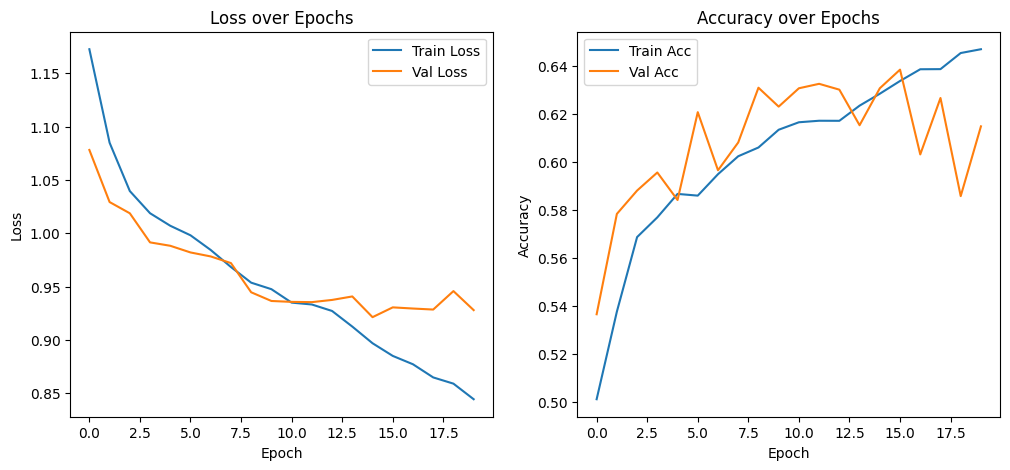

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


Accuracy: 0.6308
Macro F1: 0.5793
Macro Precision: 0.5785
Macro Recall: 0.5874

Classification Report:

              precision    recall  f1-score   support

           0     0.7511    0.7326    0.7418      1137
           1     0.4045    0.5669    0.4721       755
           2     0.4507    0.3701    0.4064      1024
           3     0.4991    0.5151    0.5069      2089
           4     0.7870    0.7525    0.7694      3624

    accuracy                         0.6308      8629
   macro avg     0.5785    0.5874    0.5793      8629
weighted avg     0.6392    0.6308    0.6331      8629



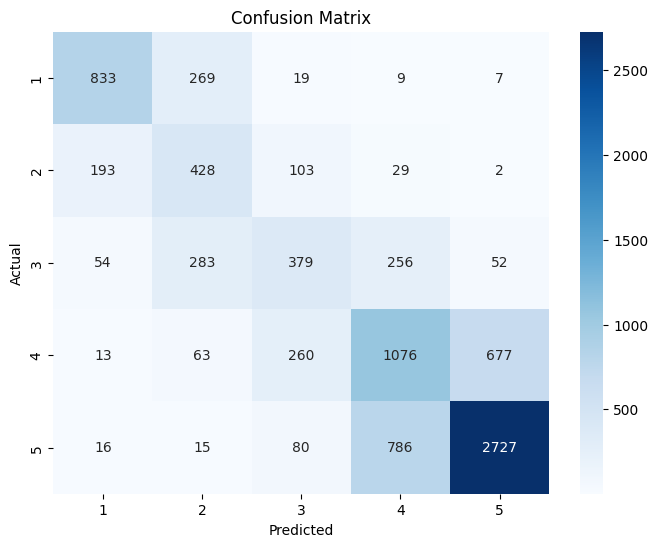

In [49]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)

all_preds = []
all_labels = []

# Iterate over test_loader
with torch.no_grad():
    for text, meta, labels in test_loader:
        text, meta = text.to(device), meta.to(device)
        outputs = model(text, meta)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
macro_precision = precision_score(all_labels, all_preds, average='macro')
macro_recall = recall_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}\n")

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
